In [1]:
# -------------------------------------
# --- Go to correct starting folder ---
# -------------------------------------
# (when running jupyter lab in the browser, the notebook starts with CWD = folder where it is located, which breaks imports, ...)
import os
import pathlib

while not ((cwd := pathlib.Path(os.getcwd())) / "pyproject.toml").exists():
    os.chdir(cwd.parent)  # go 1 folder up

In [2]:
import math
import random
from functools import partial

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from snuffled._core.analysis.function.function_analyser import FunctionSampler
from snuffled._core.analysis.roots.single_root.curve_fitting import (
    compute_x_deltas,
    fit_curve_with_uncertainty_brute_force,
    fitting_cost,
    fitting_curve,
)
from snuffled._core.analysis.roots.single_root.curve_fitting._curves_and_costs import compute_threshold_cost
from snuffled._core.analysis.roots.single_root.curve_fitting._fit_tailored import (
    fit_curve_tailored,
    fit_curve_with_uncertainty_tailored,
)
from snuffled._core.utils.noise import noise_from_float

plt.rcParams["figure.dpi"] = 300

In [3]:
def f_custom_root(
    _x: float, _e: float = 1.0, _c_step: float = 0.0, _c_quad: float = 0.0, _c_noise: float = 0.0
) -> float:
    _z = _x - 1 / math.pi
    _step = 1.0 if _z > 0 else (-1.0 if _z < 0 else 0.0)
    _quad = _z * _z
    _noise = _c_noise * noise_from_float(_x)
    _z_e = np.sign(_z) * (abs(_z) ** _e) if _z != 0.0 else 0.0
    return float(_z_e + (_c_step * _step) + (_c_quad * _quad)) * float(1 + _noise)  # relative noise
    # return float(_z_e + (_c_step * _step) + (_c_quad * _quad) + _noise)     # absolute noise

In [4]:
# -------------------------------------------------------------------------
#  Define function
# -------------------------------------------------------------------------
# fun = partial(f_custom_root, _e=10.0, _c_step=0.0, _c_quad=0.0, _c_noise=1e-1)
# fun = partial(f_custom_root, _e=5.0, _c_step=0.0, _c_quad=0.0, _c_noise=3e-2)
# fun = partial(f_custom_root, _e=2.0, _c_step=0.0, _c_quad=0.0, _c_noise=1e-2)
# fun = partial(f_custom_root, _e=1.0, _c_step=0.0, _c_quad=0.0, _c_noise=1e-2)
# fun = partial(f_custom_root, _e=0.5, _c_step=0.0, _c_quad=0.0, _c_noise=1e-2)
fun = partial(f_custom_root, _e=0.2, _c_step=0.0, _c_quad=0.0, _c_noise=3e-3)
# fun = partial(f_custom_root, _e=0.1, _c_step=0.0, _c_quad=0.0, _c_noise=1e-3)

# -------------------------------------------------------------------------
#  Sampler
# -------------------------------------------------------------------------
dx = 1e-10
sampler = FunctionSampler(
    fun=fun,
    x_min=-1.0,
    x_max=1.0,
    dx=dx,
    n_fun_samples=1000,
    n_roots=100,
    rel_tol_scale=10.0,
    seed=42,
)

In [5]:
# --- retrieve root ---------------------------------------
roots = sampler.roots()
root_min, root, root_max = roots[0].x_min, roots[0].x, roots[0].x_max

for _x in [root_min - dx, root_min, root, root_max, root_max + dx]:
    print(f"{_x:20.10e} -> {fun(_x):20.10e}")

    3.1830988608e-01 ->    -1.0025654343e-02
    3.1830988618e-01 ->    -5.6228144429e-04
    3.1830988618e-01 ->     0.0000000000e+00
    3.1830988618e-01 ->     5.6235201776e-04
    3.1830988628e-01 ->     1.0026496623e-02


In [6]:
# --- generate deltas -------------------------------------
x_deltas: np.ndarray = compute_x_deltas(
    dx=dx,
    k=10,
    seed=42,
)

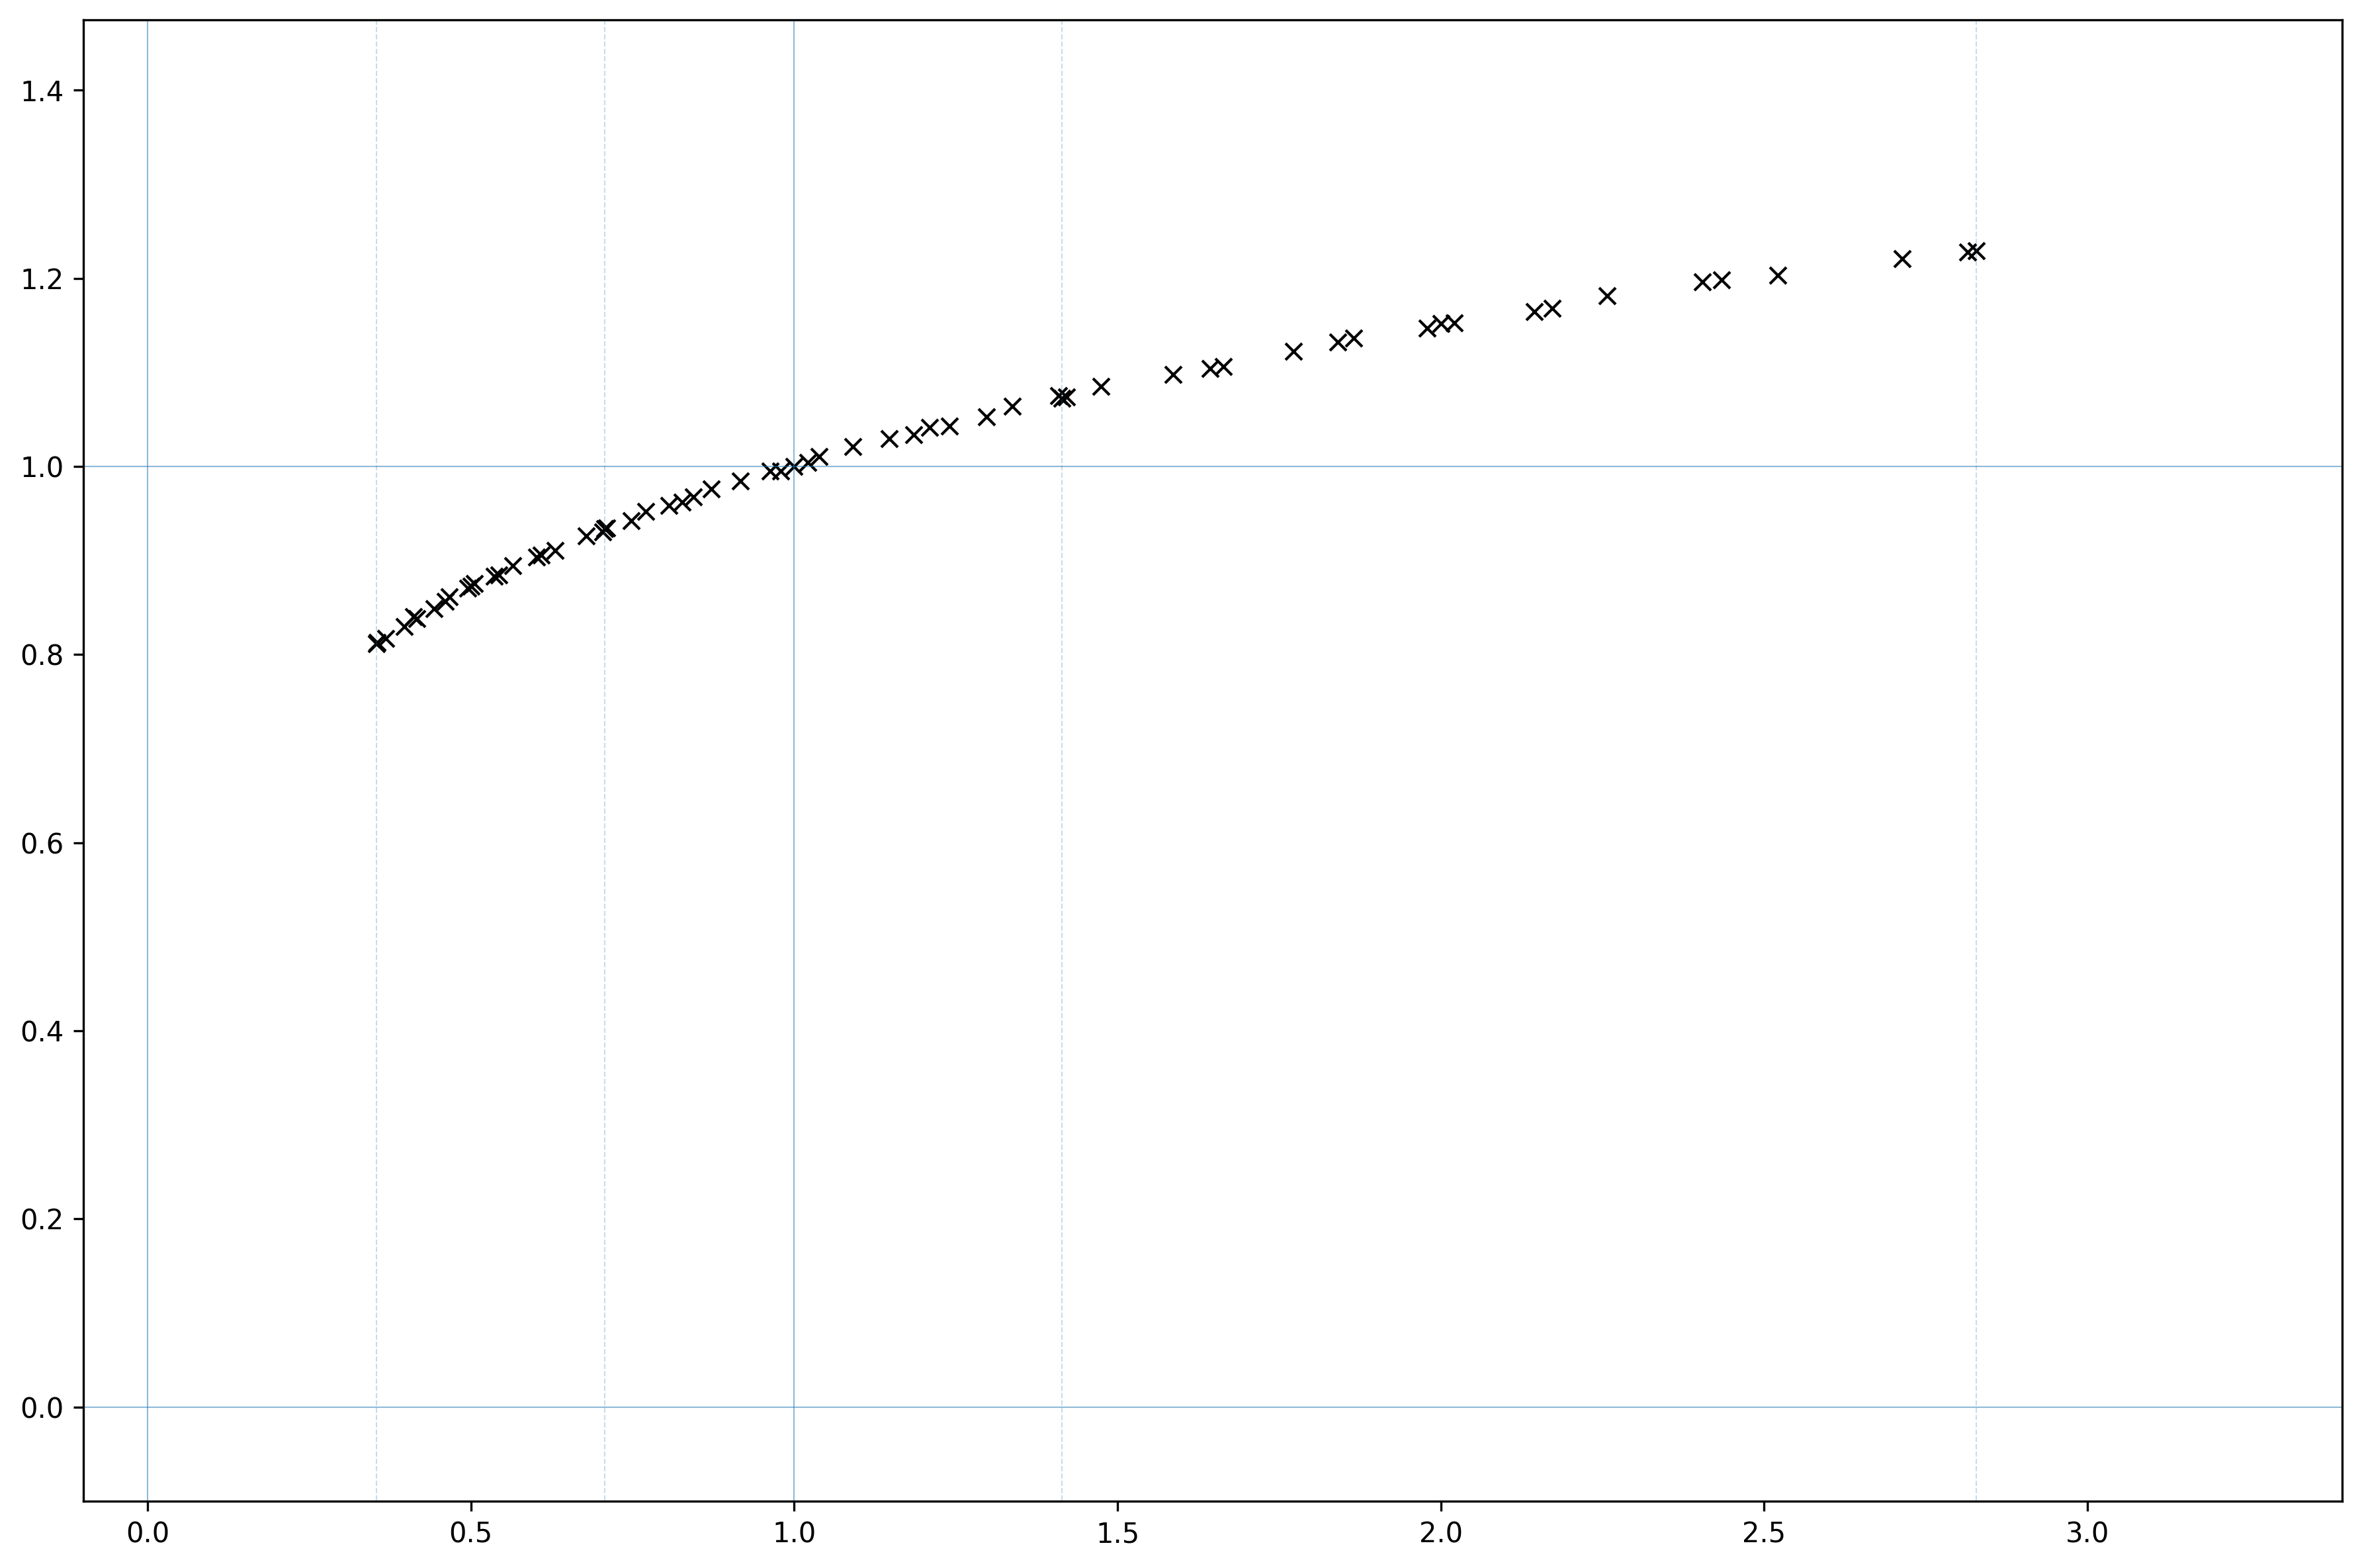

In [7]:
# --- evaluate function ---
fx_values = np.array([sampler.f(root + x_delta) for x_delta in x_deltas])

# --- normalize ---
# after this step, median(x_values)==1.0, median(fx_values)==1.0
x_values = x_deltas / (2 * dx)
fx_values = fx_values / np.median(fx_values)

fx_q25, fx_q50, fx_q75 = np.quantile(fx_values, [0.25, 0.50, 0.75])

# --- plot ---
fig, ax = plt.subplots(1, 1)
ax.plot(x_values, fx_values, "x", color="k")

# scale
x_min, x_max = -0.1 * max(x_values), 1.2 * max(x_values)
y_min, y_max = -0.1 * max(fx_values), 1.2 * max(fx_values)

ax.hlines(y=[0, 1], xmin=x_min, xmax=x_max, lw=0.5, alpha=0.5)
ax.vlines(x=[0, 1], ymin=y_min, ymax=y_max, lw=0.5, alpha=0.5)
ax.vlines(x=[2**-1.5, 2**-0.5, 2**0.5, 2**1.5], ymin=y_min, ymax=y_max, ls="--", lw=0.5, alpha=0.25)

ax.set_xlim(left=-0.1, right=x_max)
ax.set_ylim(bottom=-0.1, top=y_max)

fig.set_size_inches(w=12, h=8)
fig.tight_layout()

In [8]:
fx_abs_mean = np.average(abs(fx_values))

print(f"avg(abs(fx)) = {fx_abs_mean:12.6f}")

avg(abs(fx)) =     1.008242


# Problem Settings

In [9]:
# --- search range ----------------------------------------
b_min, b_max = -0.5, 1.0
range_b = (b_min, b_max)

c_min, c_max = 1 / 8.0, 16.0
range_c = (c_min, c_max)

# --- cost settings ---------------------------------------
reg = 1e-3
rel_uncertainty_size = 0.5

# Tailored optimization

In [10]:
a_values_t, b_values_t, c_values_t, cost_values_t = fit_curve_with_uncertainty_tailored(
    x=x_values,
    fx=fx_values,
    range_b=range_b,
    range_c=range_c,
    reg=reg,
    n_iters=20,
    rel_uncertainty_size=rel_uncertainty_size,
    debug_flag=False,
)

# --- put results in dictionary ---------------------------
results_t = {
    (
        a,
        b,
        c,
    ): cost
    for a, b, c, cost in zip(a_values_t, b_values_t, c_values_t, cost_values_t)
}

# extract optimum
cost_opt_t = min(results_t.values())
cost_threshold_t = compute_threshold_cost(
    relative_margin=rel_uncertainty_size,
    optimal_cost=cost_opt_t,
    fx_q25=fx_q25,
    fx_q50=fx_q50,
    fx_q75=fx_q75,
)

a_opt_t, b_opt_t, c_opt_t = 0.0, 0.0, 0.0
for (a, b, c), cost in results_t.items():
    if cost == cost_opt_t:
        a_opt_t, b_opt_t, c_opt_t = a, b, c

# marginal results - a
a_ok_t = sorted({a for a, b, c in results_t.keys()})
a_cost_marginal_t = [min([cost for (a, b, c), cost in results_t.items() if a == a_ok]) for a_ok in a_ok_t]

# marginal results - b
b_ok_t = sorted({b for a, b, c in results_t.keys()})
b_cost_marginal_t = [min([cost for (a, b, c), cost in results_t.items() if b == b_ok]) for b_ok in b_ok_t]

# marginal results - c
c_ok_t = sorted({c for a, b, c in results_t.keys()})
c_cost_marginal_t = [min([cost for (a, b, c), cost in results_t.items() if c == c_ok]) for c_ok in c_ok_t]

In [11]:
# --- print results ---------------------------------------
print()
print(f"TAILORED curve fitting results...")
print()
print(f"cost_opt_t       : {cost_opt_t:12.6f}")
print(f"cost_threshold_t : {cost_threshold_t:12.6f}")
print()
print(f"{len(results_t):_} below-threshold solutions:")
print(f"   a = {min(a_ok_t):12.6f} -> {max(a_ok_t):12.6f}")
print(f"   b = {min(b_ok_t):12.6f} -> {max(b_ok_t):12.6f}")
print(f"   c = {min(c_ok_t):12.6f} -> {max(c_ok_t):12.6f}")

# NOTES
#
#  15 iters, with a, b, c, bc_bal, bc_dgdx_1, bc_gx_05, bc_gx_2, a-median
#    c=10.0      -->    143.412488
#    c= 5.0      -->      0.378042
#    c= 2.0      -->      0.011155
#    c= 1.0      -->      0.006019
#    c= 0.5      -->      0.005272
#    c= 0.2      -->      0.002090
#    c= 0.1      -->      0.001684
#
#  15 iters, with a, b, c, bc_bal, a-median
#    c=10.0      -->    143.412488
#    c= 5.0      -->      0.379399
#    c= 2.0      -->      0.011156
#    c= 1.0      -->      0.006038
#    c= 0.5      -->      0.005323
#    c= 0.2      -->      0.002091
#    c= 0.1      -->      0.001684
#
#  15 iters, with a, b, c, ac_bal, bc_bal, a-median
#    c=10.0      -->    135.550833
#    c= 5.0      -->      0.375029
#    c= 2.0      -->      0.011156
#    c= 1.0      -->      0.006058
#    c= 0.5      -->      0.005323
#    c= 0.2      -->      0.002091
#    c= 0.1      -->      0.001684
#
#  15 iters, with a, b, c, ac_bal, bc_bal
#    c=10.0      -->    135.550833
#    c= 5.0      -->      0.378179
#    c= 2.0      -->      0.011156
#    c= 1.0      -->      0.006034
#    c= 0.5      -->      0.005325
#    c= 0.2      -->      0.002088
#    c= 0.1      -->      0.001690
#
#  15 iters, with a, b, c, ab, ac, bc
#    c=10.0      -->    135.834545
#    c= 5.0      -->      0.373365
#    c= 2.0      -->      0.011156
#    c= 1.0      -->      0.006034
#    c= 0.5      -->      0.005325
#    c= 0.2      -->      0.002088
#    c= 0.1      -->      0.001690


TAILORED curve fitting results...

cost_opt_t       :     0.002261
cost_threshold_t :     0.003992

65 below-threshold solutions:
   a =     0.997793 ->     1.004329
   b =    -0.416087 ->     0.270140
   c =     0.142126 ->     0.273076


# Brute Force optimization

In [12]:
# --- reuse a_opt from tailored optim. ? ------------------
reuse_a_opt_t = True

# --- call grid search ------------------------------------
n_grid = 4 * (15 * 24) + 1
a_values_bf, b_values_bf, c_values_bf, cost_values_bf = fit_curve_with_uncertainty_brute_force(
    x=x_values,
    fx=fx_values,
    range_b=range_b,
    range_c=range_c,
    c_sign=1.0,
    n_grid=n_grid,
    reg=reg,
    rel_uncertainty_size=rel_uncertainty_size,
    fixed_a_value=a_opt_t if reuse_a_opt_t else None,
)

# --- put results in dictionary ---------------------------
results_bf = {
    (
        a,
        b,
        c,
    ): cost
    for a, b, c, cost in zip(a_values_bf, b_values_bf, c_values_bf, cost_values_bf)
}

# extract optimum
cost_opt_bf = min(results_bf.values())
cost_threshold_bf = compute_threshold_cost(
    relative_margin=rel_uncertainty_size,
    optimal_cost=cost_opt_bf,
    fx_q25=fx_q25,
    fx_q50=fx_q50,
    fx_q75=fx_q75,
)

a_opt_bf, b_opt_bf, c_opt_bf = 0.0, 0.0, 0.0
for (a, b, c), cost in results_bf.items():
    if cost == cost_opt_bf:
        a_opt_bf, b_opt_bf, c_opt_bf = a, b, c

# marginal results - a
a_ok_bf = sorted({a for a, b, c in results_bf.keys()})
a_cost_marginal_bf = [min([cost for (a, b, c), cost in results_bf.items() if a == a_ok]) for a_ok in a_ok_bf]

# marginal results - b
b_ok_bf = sorted({b for a, b, c in results_bf.keys()})
b_cost_marginal_bf = [min([cost for (a, b, c), cost in results_bf.items() if b == b_ok]) for b_ok in b_ok_bf]

# marginal results - c
c_ok_bf = sorted({c for a, b, c in results_bf.keys()})
c_cost_marginal_bf = [min([cost for (a, b, c), cost in results_bf.items() if c == c_ok]) for c_ok in c_ok_bf]

In [13]:
# --- print results ---------------------------------------
print()
print(f"BRUTE FORCE grid search results...")
print()
print(f"cost_opt_bf       : {cost_opt_bf:12.6f}")
print(f"cost_threshold_bf : {cost_threshold_bf:12.6f}")
print()
print(f"{len(results_bf):_} below-threshold solutions:")
print(f"   a = {min(a_ok_bf):12.6f} -> {max(a_ok_bf):12.6f}")
print(f"   b = {min(b_ok_bf):12.6f} -> {max(b_ok_bf):12.6f}")
print(f"   c = {min(c_ok_bf):12.6f} -> {max(c_ok_bf):12.6f}")


BRUTE FORCE grid search results...

cost_opt_bf       :     0.002262
cost_threshold_bf :     0.003993

9_210 below-threshold solutions:
   a =     1.000768 ->     1.000768
   b =    -0.423958 ->     0.272917
   c =     0.142075 ->     0.272234


# Visualize cost function & results

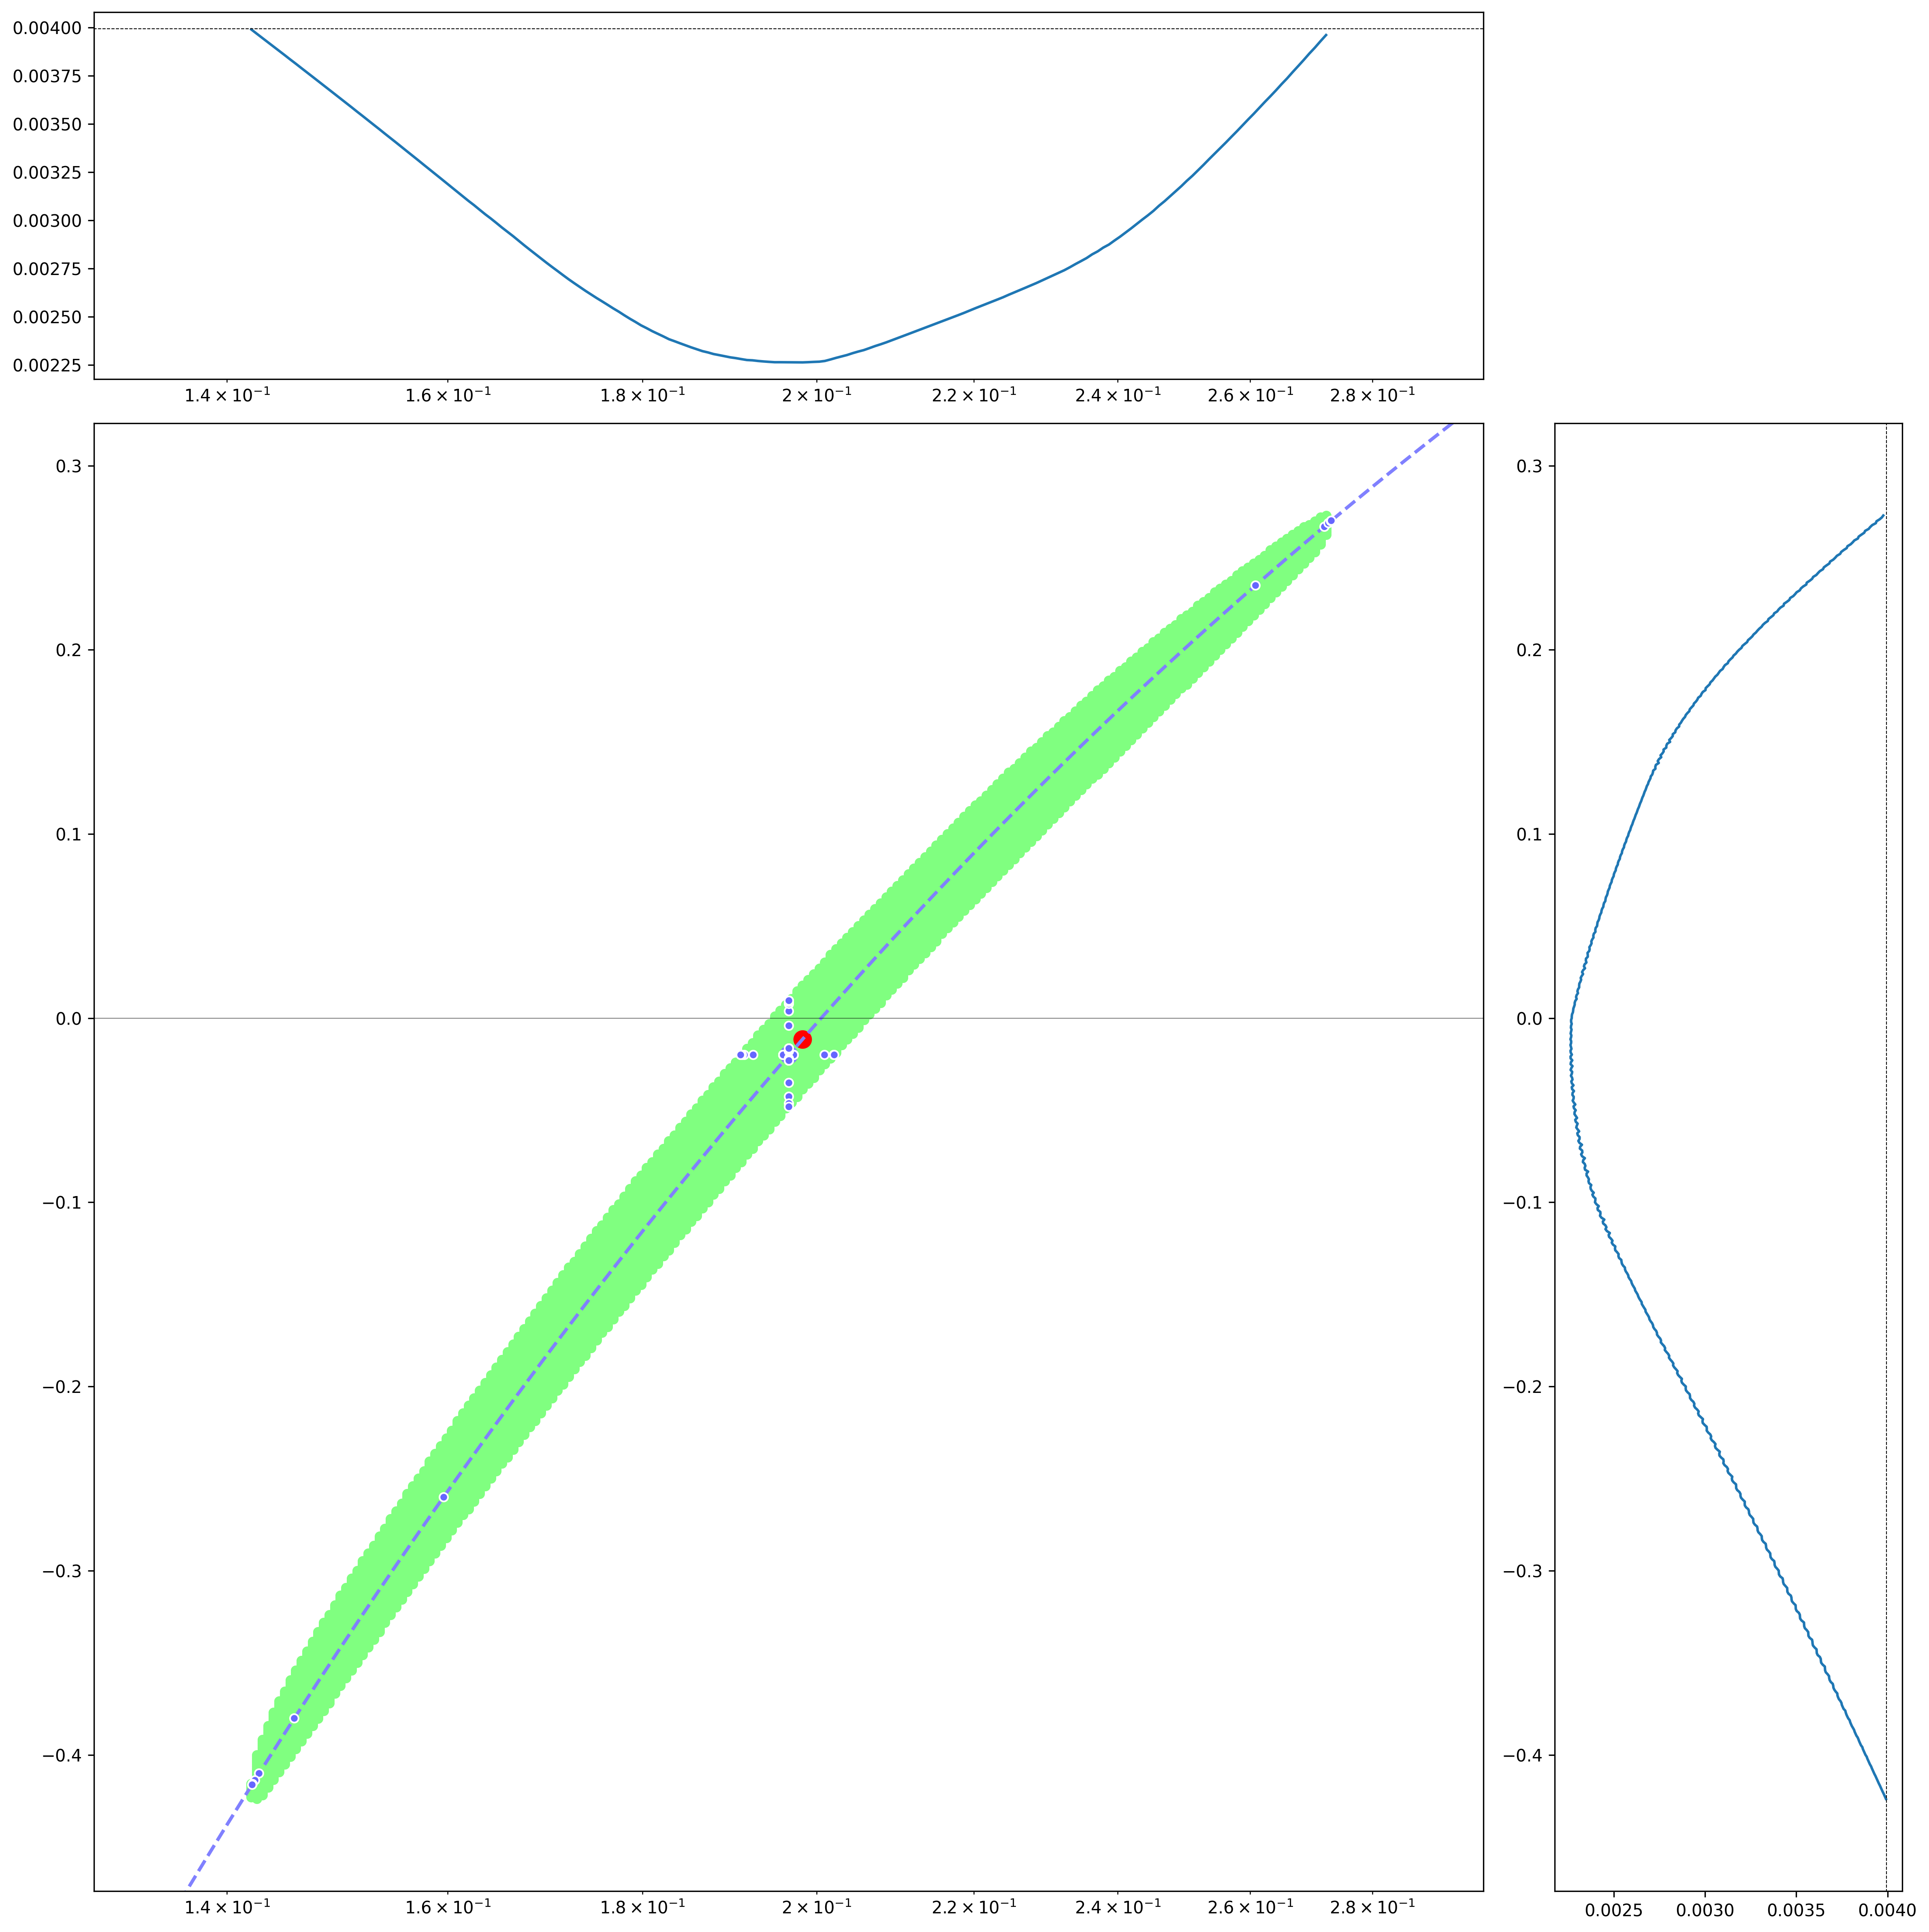

In [14]:
# -------------------------------------------------------------------------
#  Plot settings
# -------------------------------------------------------------------------
plot_zoomed = True

# -------------------------------------------------------------------------
#  Create plot
# -------------------------------------------------------------------------

# 3 axes
#   C = central one for 2d plots
#   E = top one for plotting cost(e)
#   S = right one for plotting cost(c_step)
layout = """
    E.
    CS
"""

# Create figure and axes using the mosaic layout
fig, axes = plt.subplot_mosaic(
    layout,
    gridspec_kw={"height_ratios": [1, 4], "width_ratios": [4, 1]},
    empty_sentinel=".",
)

# make sure axes are linked and shared correctly
axes["C"].sharex(axes["E"])
axes["C"].sharey(axes["S"])


# -------------------------------------------------------------------------
#  2D plot
# -------------------------------------------------------------------------
ax = axes["C"]
ax.semilogx()

# --- reference lines -------------------------------------
# b
ax.plot([c_min / 10, c_max * 10], [b_min, b_min], lw=0.5, zorder=10, alpha=0.5, color="k")
ax.plot([c_min / 10, c_max * 10], [0.0, 0.0], lw=0.5, zorder=10, alpha=0.5, color="k")
ax.plot([c_min / 10, c_max * 10], [b_max, b_max], lw=0.5, zorder=10, alpha=0.5, color="k")
# c
ax.plot([c_min, c_min], [b_min - 1, b_max + 1], lw=0.5, zorder=10, alpha=0.5, color="k")
ax.plot([1, 1], [b_min - 1, b_max + 1], lw=0.5, zorder=10, alpha=0.5, color="k")
ax.plot([c_max, c_max], [b_min - 1, b_max + 1], lw=0.5, zorder=10, alpha=0.5, color="k")

# --- organize brute-force data ---------------------------
data_opt = set()  # (b, c)-tuples that are optimal
data_ok = set()  # (b, c)-tuples below threshold (but not optimal)
for (a, b, c), cost in results_bf.items():
    if cost == cost_opt_bf:
        data_opt.add((b, c))
    else:
        data_ok.add((b, c))

# --- plot brute-force data -------------------------------
for data_tuples, (mc, ms), enabled in zip(
    [data_ok, data_opt],
    [
        ((0.5, 1, 0.5), 5 if plot_zoomed else 1),
        ("r", 10 if plot_zoomed else 5),
    ],
    [True, True],
):
    if enabled:
        x = [c for b, c in data_tuples]
        y = [b for b, c in data_tuples]
        ax.plot(x, y, c=mc, ms=ms, marker="o", lw=0)

# -------------------------------------------------------------------------
#  Plot curve for equal dg/dx(x=1)
# -------------------------------------------------------------------------
_b_lst = np.linspace(-0.5, 0.999, 1000)
# # this means we keep (1 - b)*c constant
# dgdx_1_opt = (1 - b_opt_bf) * c_opt_bf
# _c_lst = [dgdx_1_opt / (1 - _b) for _b in _b_lst]
#
# ax.plot(_c_lst, _b_lst, color="k", lw=1, ls="--", alpha=1)


# -------------------------------------------------------------------------
#  Plot curve for equal g(x=2**1.5)
# -------------------------------------------------------------------------
# g28_opt = b_opt_bf + (1 - b_opt_bf) * (2 ** (1.5 * c_opt_bf))
# # we need to vary b, c such that c = log2( (g2_opt - b) / (1-b) ) / 1.5
# _c_lst = [math.log2(max(1e-12, (g28_opt - _b) / (1 - _b))) / 1.5 for _b in _b_lst]
#
# ax.plot(_c_lst, _b_lst, color="k", lw=1, ls="-.", alpha=1)

# -------------------------------------------------------------------------
#  Plot curve for equal g(x=2)
# -------------------------------------------------------------------------
# g2_opt = b_opt_bf + (1 - b_opt_bf) * (2**c_opt_bf)
# # we need to vary b, c such that c = log2( (g2_opt - b) / (1-b) )
# _c_lst = [math.log2(max(1e-12, (g2_opt - _b) / (1 - _b))) for _b in _b_lst]
#
# ax.plot(_c_lst, _b_lst, color="k", lw=1, ls=":", alpha=1)

# -------------------------------------------------------------------------
#  Plot curve for equal g(x=0.5)
# -------------------------------------------------------------------------
# g05_opt = b_opt_bf + (1 - b_opt_bf) * (0.5**c_opt_bf)
# # we need to vary b, c such that c = log2( (g05_opt - b) / (1-b) )
# _c_lst = [-math.log2(max(1e-12, (g05_opt - _b) / (1 - _b))) for _b in _b_lst]
#
# ax.plot(_c_lst, _b_lst, color="k", lw=1, ls="-", alpha=1)

# -------------------------------------------------------------------------
#  Plot curve for equal g(r) - g(1/r)
# -------------------------------------------------------------------------
r = 2.0**1.5  # =max(x_values) by definition
ln_r = math.log(r)
# FROM NOTES: c = asinh( (1-b')*2*sinh(ln(r)*c') / (2*(1-b)) ) / ln(r)
#               = asinh( (1-b') * sinh(ln(r)*c') /    (1-b)  ) / ln(r)
#               = asinh(          cte            /    (1-b)  ) / ln(r)
_cte = (1 - b_opt_bf) * math.sinh(ln_r * c_opt_bf)
_c_lst = [math.asinh(_cte / max(1e-12, (1 - _b))) / ln_r for _b in _b_lst]

ax.plot(_c_lst, _b_lst, color=(0.5, 0.5, 1.0), lw=2, ls="--", alpha=1)

# -------------------------------------------------------------------------
#  Plot ranges
# -------------------------------------------------------------------------
if plot_zoomed:
    # zoom in on acceptable results
    ax.set_xlim(left=min(c_ok_bf) / 1.1, right=max(c_ok_bf) * 1.1)
    ax.set_ylim(bottom=min(b_ok_bf) - 0.05, top=max(b_ok_bf) + 0.05)
else:
    # full analysis range
    ax.set_xlim(left=c_min, right=c_max)
    ax.set_ylim(bottom=b_min, top=b_max)

# -------------------------------------------------------------------------
#  Plot tailored solution + uncertainty
# -------------------------------------------------------------------------

# optimal solution
ax.plot(c_opt_t, b_opt_t, color=(0.5, 0.5, 1.0), lw=0, marker="o", ms=10 if plot_zoomed else 5)

# extract uncertainty
x_unc_t = []
y_unc_t = []
for (a, b, c), cost in results_t.items():
    if cost > cost_opt_t:
        x_unc_t.append(c)
        y_unc_t.append(b)

ax.plot(x_unc_t, y_unc_t, color=(0.4, 0.4, 1.0), mec="w", lw=0, marker="o", ms=5 if plot_zoomed else 3)


# -------------------------------------------------------------------------
#  Plot optimal_cost(b)
# -------------------------------------------------------------------------
ax = axes["S"]
ax.plot(b_cost_marginal_bf, b_ok_bf)
ax.plot([cost_threshold_bf, cost_threshold_bf], [b_min - 1, b_max + 1], lw=0.5, ls="--", color="k")

# -------------------------------------------------------------------------
#  Plot optimal_cost(c)
# -------------------------------------------------------------------------
ax = axes["E"]
ax.plot(c_ok_bf, c_cost_marginal_bf)
ax.plot([c_min / 10, c_max * 10], [cost_threshold_bf, cost_threshold_bf], lw=0.5, ls="--", color="k")


# -------------------------------------------------------------------------
#  Overall layout
# -------------------------------------------------------------------------
fig.set_size_inches(w=16, h=16)
fig.tight_layout()

# Visualize solutions in (x,fx)-space

In [15]:
print(len(data_ok))

9209


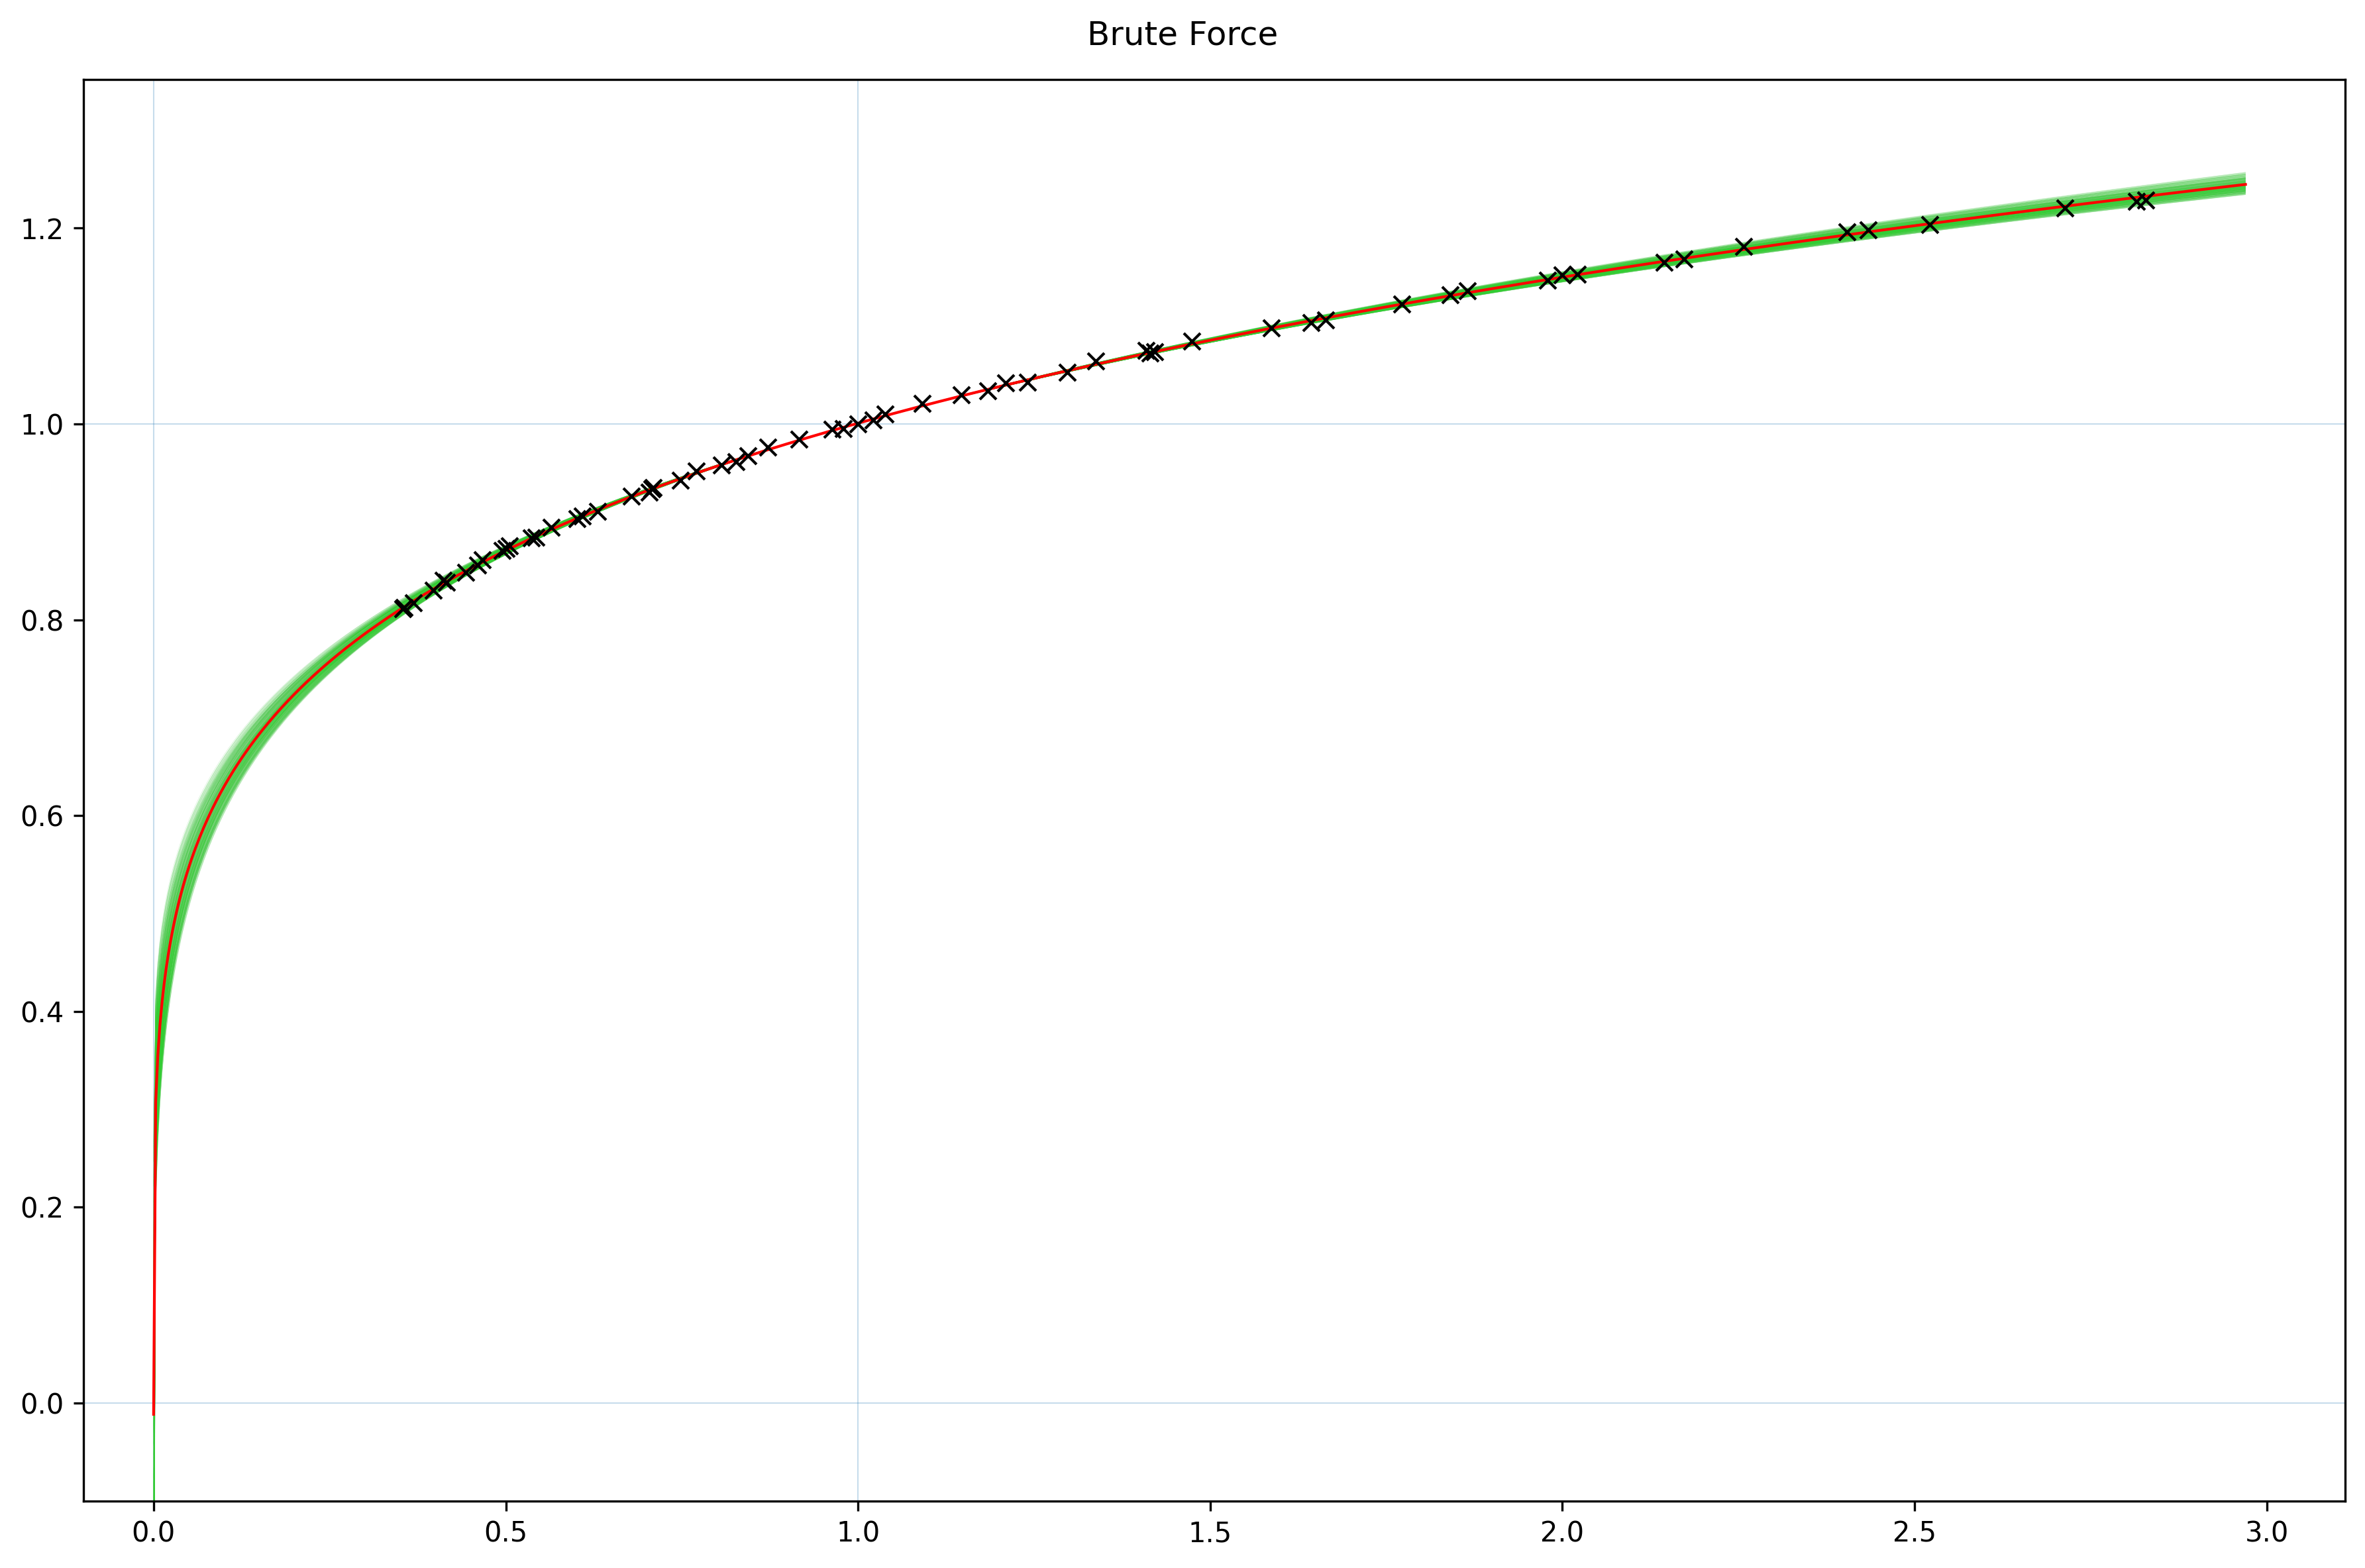

In [16]:
# -------------------------------------------------------------------------
#  Figure / Axes
# -------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1)

# -------------------------------------------------------------------------
#  Plot data
# -------------------------------------------------------------------------

# --- reference lines -------------------------------------
ax.hlines(y=[0, 1], xmin=-1, xmax=2 * max(x_values), lw=0.5, alpha=0.25)
ax.vlines(x=[0, 1], ymin=-1, ymax=2 * max(fx_values), lw=0.5, alpha=0.25)

# --- fitted curves ---------------------------------------
curve_x = np.linspace(0.0, 1.05 * max(x_values), 1000)
n_ok_curves = min(1000, len(data_ok))
thickness = n_ok_curves ** (-1 / 3)
for data_tuples, (lc, lw, alpha), enabled in zip(
    [data_ok, data_opt], [((0.2, 0.8, 0.2), thickness, thickness), ("r", 1, 1.0)], [True, True]
):
    if enabled:
        if len(data_tuples) > 1000:
            data_tuples = random.sample(list(data_tuples), k=1000)
        for b, c in data_tuples:
            curve_fx = fitting_curve(curve_x, a=a_ok_bf[0], b=b, c=c)
            ax.plot(curve_x, curve_fx, c=lc, lw=lw, alpha=alpha)

# --- x,fx data -------------------------------------------
ax.plot(x_values, fx_values, "x", color="k")

ax.set_xlim(left=-0.1, right=1.1 * max(x_values))
ax.set_ylim(bottom=-0.1, top=1.1 * max(fx_values))

# -------------------------------------------------------------------------
#  Figure layout
# -------------------------------------------------------------------------
fig.suptitle("Brute Force")
fig.set_size_inches(w=12, h=8)
fig.tight_layout()

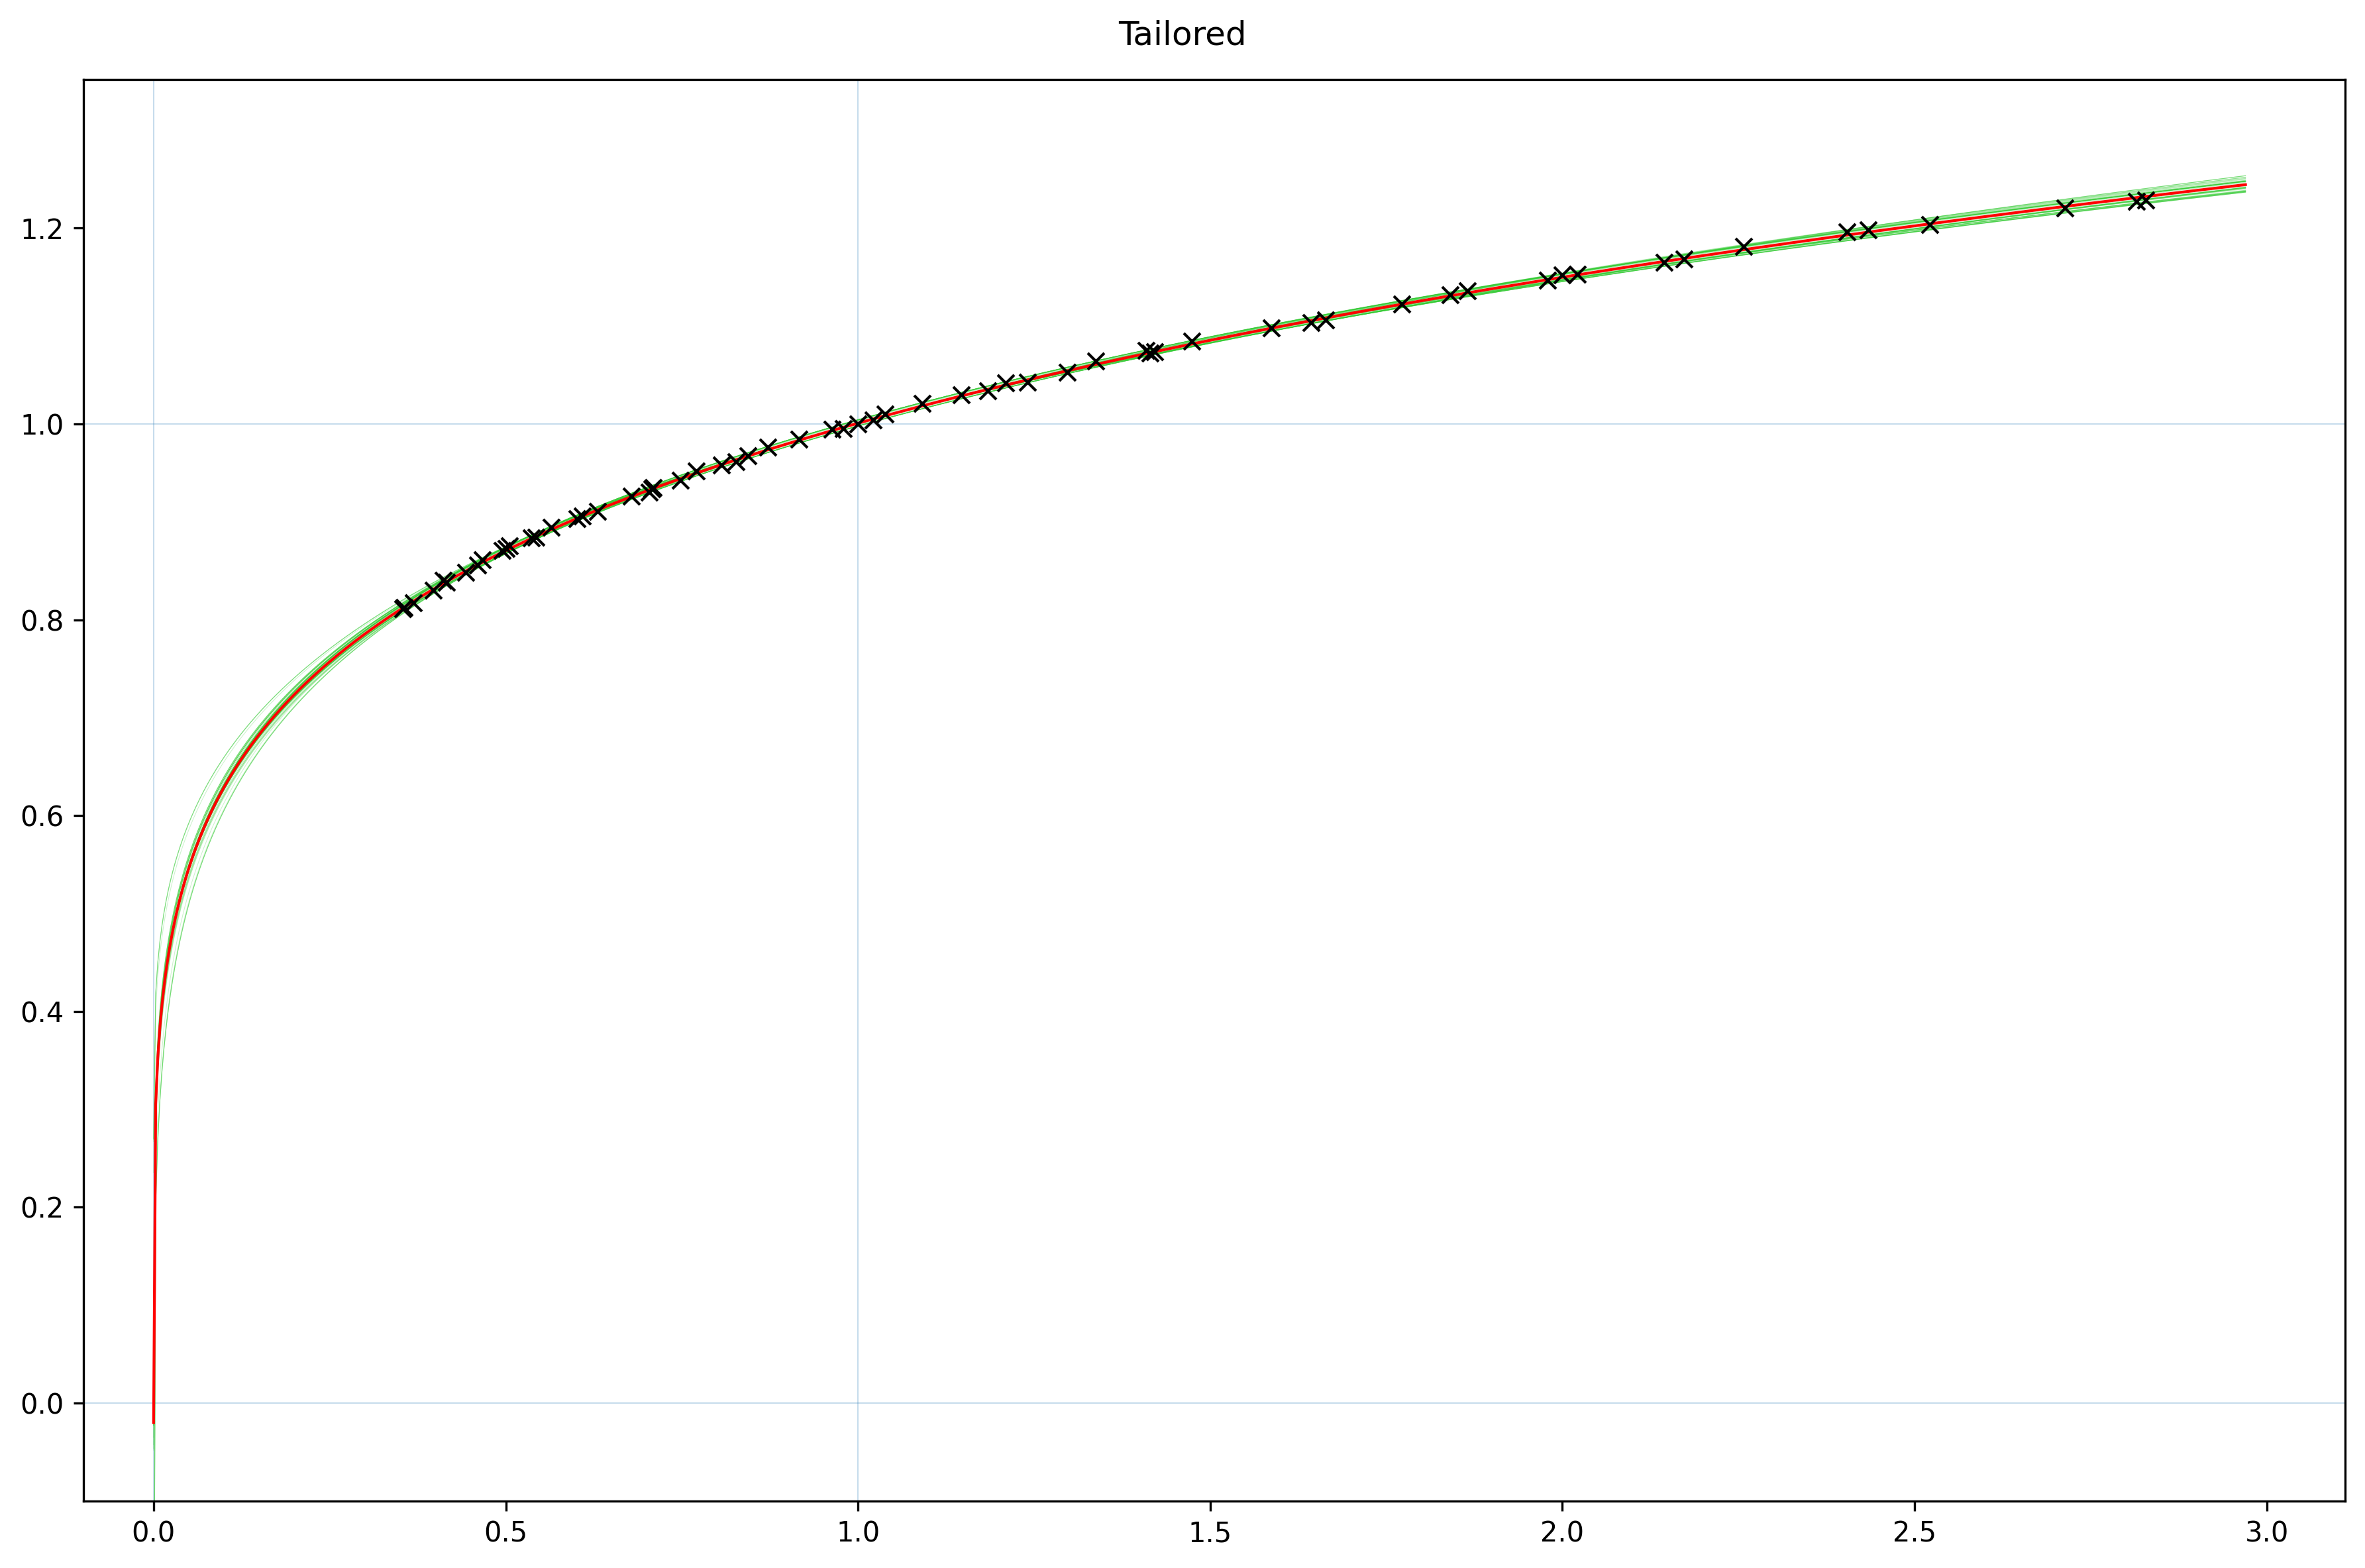

In [17]:
# -------------------------------------------------------------------------
#  Figure / Axes
# -------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1)

# -------------------------------------------------------------------------
#  Plot data
# -------------------------------------------------------------------------

# --- extract tailored (a,b,c) tuples ---------------------
data_opt = [(a_opt_t, b_opt_t, c_opt_t)]

data_ok = []
for (a, b, c), cost in results_t.items():
    if cost > cost_opt_t:
        data_ok.append((a, b, c))

# --- reference lines -------------------------------------
ax.hlines(y=[0, 1], xmin=-1, xmax=2 * max(x_values), lw=0.5, alpha=0.25)
ax.vlines(x=[0, 1], ymin=-1, ymax=2 * max(fx_values), lw=0.5, alpha=0.25)

# --- fitted curves ---------------------------------------
curve_x = np.linspace(0.0, 1.05 * max(x_values), 1000)
n_ok_curves = min(1000, len(data_ok))
thickness = n_ok_curves ** (-1 / 3)
for data_tuples, (lc, lw, alpha), enabled in zip(
    [data_ok, data_opt], [((0.2, 0.8, 0.2), thickness, thickness), ("r", 1, 1.0)], [True, True]
):
    if enabled:
        if len(data_tuples) > 1000:
            data_tuples = random.sample(list(data_tuples), k=1000)
        for a, b, c in data_tuples:
            curve_fx = fitting_curve(curve_x, a=a, b=b, c=c)
            ax.plot(curve_x, curve_fx, c=lc, lw=lw, alpha=alpha)

# --- x,fx data -------------------------------------------
ax.plot(x_values, fx_values, "x", color="k")

ax.set_xlim(left=-0.1, right=1.1 * max(x_values))
ax.set_ylim(bottom=-0.1, top=1.1 * max(fx_values))

# -------------------------------------------------------------------------
#  Figure layout
# -------------------------------------------------------------------------
fig.suptitle("Tailored")
fig.set_size_inches(w=12, h=8)
fig.tight_layout()